In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [17]:
import hosts

import shutil
import requests

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar
from astropy.utils import data

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)

In [5]:
SDSS_SQL_URL = 'http://skyserver.sdss.org/dr13/SkyServerWS/SearchTools/SqlSearch'

def in_sdss(sc):
    res = requests.get(SDSS_SQL_URL, dict(cmd="select dbo.fInFootprintEq({0.ra.deg},{0.dec.deg},0.1)".format(sc), 
                                          format='csv'))
    return 'True' in res.text.split('\n')

In [6]:
ls decals_dr4/

survey-bricks-dr4.fits.gz  survey-bricks.fits.gz


In [7]:
bricks = Table.read('decals_dr4/survey-bricks.fits.gz')

bricksdr = Table.read('decals_dr4/survey-bricks-dr4.fits.gz')

fn_in_sdss = 'decals_dr4/in_sdss.npy'

try:
    bricksdr['in_sdss'] = np.load(fn_in_sdss)
except:
    bricksdr['in_sdss'] = ['unknown']*len(bricksdr)
bricksdr

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,ebv,trans_g,trans_r,trans_z,ext_g,ext_r,ext_z,wise_nobs [4],trans_wise [4],ext_w1,ext_w2,ext_w3,ext_w4,in_sdss
str8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,str7
0556p332,55.671641791,33.25,0,0,8,0 .. 0,0 .. 0,3983213 .. 6869231,2434,1716,424,188,100,6,0.0,0.0,1.10044,0.0,0.0,23.5382,0.0,0.0,23.1585,0.498528,0.228609,0.370062,0.573473,1.60227,1.07931,0.603717,70 .. 12,0.918985 .. 0.99583,0.0917291,0.0563336,0.0120145,0.0045366,unknown
0557p330,55.7851239669,33.0,0,0,6,0 .. 0,0 .. 0,3515900 .. 6151845,2308,1646,381,178,99,4,0.0,0.0,1.12777,0.0,0.0,23.5938,0.0,0.0,23.2322,0.528384,0.209271,0.348674,0.554691,1.69823,1.14395,0.639873,74 .. 12,0.914347 .. 0.995581,0.0972226,0.0597073,0.012734,0.00480827,unknown
0557p335,55.7641196013,33.5,0,0,10,0 .. 0,0 .. 0,335689 .. 8918538,3409,2322,567,297,208,15,0.0,0.0,1.08877,0.0,0.0,23.6377,0.0,0.0,23.2558,0.55702,0.192263,0.329322,0.537254,1.79026,1.20595,0.674551,73 .. 12,0.90992 .. 0.995342,0.102492,0.0629433,0.0134242,0.0050689,unknown
0559p332,55.9701492537,33.25,0,0,10,0 .. 0,0 .. 0,8565 .. 11524237,3843,2595,694,332,210,12,0.0,0.0,1.10383,0.0,0.0,23.5416,0.0,0.0,23.1777,0.567837,0.186204,0.322295,0.530811,1.82503,1.22937,0.687651,72 .. 13,0.908254 .. 0.995252,0.104482,0.0641656,0.0136849,0.00516734,unknown
0560p330,56.0826446281,33.0,0,0,6,0 .. 0,0 .. 0,3395289 .. 6321674,2243,1566,416,159,98,4,0.0,0.0,1.15255,0.0,0.0,23.4639,0.0,0.0,23.1147,0.616166,0.161383,0.292685,0.502955,1.98036,1.334,0.746177,74 .. 12,0.900845 .. 0.994849,0.113374,0.0696267,0.0148496,0.00560712,unknown
0560p335,56.0631229236,33.5,0,0,10,0 .. 0,0 .. 0,60892 .. 9782339,3390,2384,590,256,145,15,0.0,0.0,1.09524,0.0,0.0,23.6286,0.0,0.0,23.2468,0.559281,0.19098,0.327841,0.535901,1.79753,1.21084,0.677289,73 .. 13,0.909572 .. 0.995323,0.102908,0.0631987,0.0134787,0.00508944,unknown
0562p332,56.2686567164,33.25,0,0,9,0 .. 0,0 .. 0,1228886 .. 9607509,3287,2354,528,270,128,7,0.0,0.0,1.13715,0.0,0.0,23.5552,0.0,0.0,23.2001,0.633924,0.153118,0.282502,0.493091,2.03743,1.37245,0.767682,74 .. 13,0.898138 .. 0.994701,0.116642,0.0716334,0.0152776,0.00576871,unknown
0563p330,56.3801652893,33.0,0,0,0,0 .. 0,0 .. 0,7450967 .. 2821842,1156,820,187,96,46,7,0.0,0.0,1.17665,0.0,0.0,23.4711,0.0,0.0,23.132,0.647852,0.146934,0.274764,0.48549,2.0822,1.4026,0.784549,73 .. 13,0.896021 .. 0.994585,0.119205,0.0732073,0.0156133,0.00589546,unknown
0563p335,56.3621262458,33.5,0,0,2,0 .. 0,0 .. 0,5186227 .. 4945981,1841,1402,244,119,71,5,0.0,0.0,1.12285,0.0,0.0,23.6427,0.0,0.0,23.2754,0.562955,0.188914,0.325448,0.533709,1.80934,1.2188,0.681738,74 .. 13,0.909006 .. 0.995293,0.103584,0.0636139,0.0135672,0.00512286,unknown


In [8]:
goodbricks = (bricksdr['in_sdss'] == 'unknown') & (bricksdr['nexp_r']>=10)

if np.sum(goodbricks) > 0:
    for brick in ProgressBar(bricksdr[goodbricks], ipython_widget=True):
        sc = SkyCoord(brick['ra']*u.deg, brick['dec']*u.deg)
        bricksdr['in_sdss'][bricksdr['brickname']==brick['brickname']] = 'yes' if in_sdss(sc) else 'no'

    np.save(fn_in_sdss, bricksdr['in_sdss'])

(25, 90)

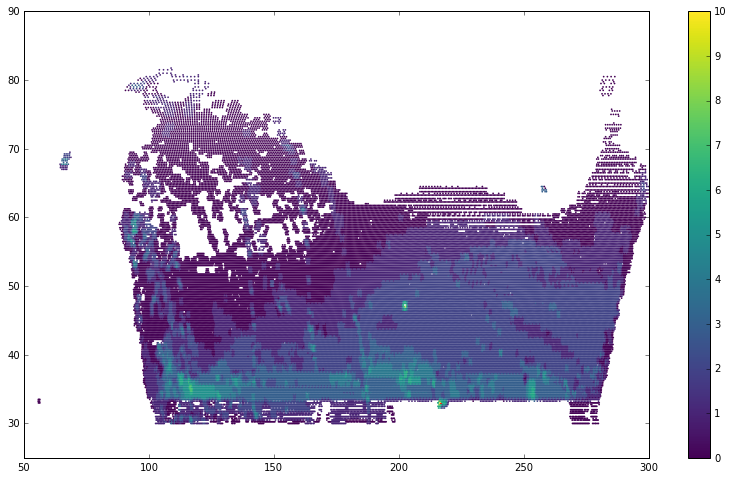

In [24]:
#plt.subplot(projection='hammer')
ra = Angle(bricksdr['ra'], u.deg).wrap_at(360*u.deg).deg
dec = Angle(bricksdr['dec'], u.deg).deg

plt.scatter(ra, dec, 
            c=bricksdr['nexp_r'], lw=0, s=3, vmin=0)
plt.colorbar()


yeses = bricksdr['in_sdss'] == 'yes'
nos = bricksdr['in_sdss'] == 'no'
plt.scatter(ra[yeses], dec[yeses], c='r',lw=0, s=1)
plt.scatter(ra[nos], dec[nos], c='w',lw=0, s=1)

plt.xlim(50, 300)
plt.ylim(25, 90)

In [34]:
hostlst = hosts.get_saga_hosts_from_google()

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [36]:
for host in hostlst:
    host

In [38]:
host.coords

<SkyCoord (ICRS): (ra, dec) in deg
    (344.33144922, -1.04903473)>